# "Concevez une application au service de la santé publique"
_Analysis Notebook_

In [2]:
# Checking whether the notebook is on Colab or PC

import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

In [3]:
# Mounting myDrive if on colab

if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Mounted at /gdrive
/gdrive
You're on Google Colab


In [0]:
import os
if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET3':
    os.chdir('My Drive/--DATA SCIENCE/PROJET3')

In [0]:
# Noticing user about files that has to be in the current working directory

def file_required(file_name):
    if os.path.exists(os.getcwd()+"/"+file_name):
        print("OK, loading "+file_name+"\
                           from the current working directory ...")
    else:
        print("Please, put "+file_name+"\
                           in the current working directory")

In [6]:
# Installations and importations required for Google Colab version
# May need to reboot the environment

if is_colab==True:
    !pip install -r "requirements.txt"
    !pip install ppscore
    !pip install simplejson
    !pip install mlxtend
    !pip install gTTS
else:
    # make sure 'requirements.txt' is in the current working directory
    file_required('requirements.txt')
    !pip install -r requirements.txt

In [0]:
import os
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import simplejson as json
import missingno as msno
import ppscore as pps

import joblib
from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
# from sklearn import metrics
from sklearn.impute import KNNImputer
# from sklearn.dummy import DummyRegressor, DummyClassifier
# from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from statsmodels.graphics.gofplots import qqplot

plt.rcParams['figure.facecolor']='w'

# To play audio text-to-speech during execution
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

# Get list of dtype from json
f = open('d_types.json', 'r')
d_types = json.loads(f.read().replace('datetime64', 'object'))

In [0]:
def print_null_pct(df):
    tot_null = df.isna().sum().sum()
    print('nb of null: ', tot_null, '\npct of null: ',
        '{:.1f}'.format(tot_null*100/(df.shape[0]*df.shape[1])))

In [0]:
# Import cleaned dataset

df = pd.read_csv('OFF_Cleaned.csv',
                 index_col='Unnamed: 0', dtype=d_types,
                 low_memory=False, encoding ='utf-8')
df['created_datetime'] = pd.to_datetime(df['created_datetime'])

In [10]:
# Checking columns in df

for i, c in enumerate(df.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')


code | code_val | categories_main | categories_tuple | url | main_category | 
quantity_unit | quantity_num | serving_quantity | quantity_type | labels_main | labels_tuple | 
pnns2 | pnns1 | creator | created_datetime | product_name | countries_main | 
brands_main | packaging_main | packaging_tuple | brands_tuple | allergens_main | allergens_tuple | 
countries_tuple | ingredients_text | additives_main | traces_main | traces_tuple | additives_tuple | 
additives_n | nutriscore | nutrigrade | nova_group | fat_100g | saturated_fat_100g | 
carbohydrates_100g | sugars_100g | fiber_100g | proteins_100g | salt_100g | sodium_100g | 
energy_from_fat_kj_100g | energy_kj_100g | ing_from_palm_oil_n | 

## 0 Preliminaries

In [13]:
print(df.shape)
print_null_pct(df) #(563352, 45) nb of null:  4562871 pct of null:  18.0

(564784, 45)
nb of null:  2129999 
pct of null:  8.4


In [0]:
# Displaying number of missing values per column

def plot_export_missing(df, cols, n_file, title,
                        shorten_label=False, figsize=(12,8)):
    with plt.style.context('default'):
        fig, axs = plt.subplots(2,1)
        msno.matrix(df[cols] , sparkline=False,
                    fontsize=11, ax=axs[0])
        msno.bar(df[cols], ax=axs[1], fontsize=11)
        if shorten_label:
            for ax in axs:
                lab = [item.get_text() for item in ax.get_xticklabels()]
                short_lab = [s[:7]+'...'+s[-7:] if len(s)>14 else s for s in lab]
                ax.axes.set_xticklabels(short_lab)
    fig.set_size_inches(figsize)
    [ax.grid() for ax in axs.flatten()];
    [sns.despine(ax=ax, right=False, left=False,top=False, bottom=False)\
                                        for ax in axs.flatten()];
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    fig.suptitle(title, fontweight='bold', fontsize=14)
    if not os.path.exists(os.getcwd()+'/FIG'):
        os.makedirs('FIG')
    plt.savefig(os.getcwd()+'/FIG/'+n_file, dpi=400);
    plt.show()

In [0]:
# Temporary (already changed in P3_Cleaning)
df['additives_n'] = df['additives_n'].clip(0,20)

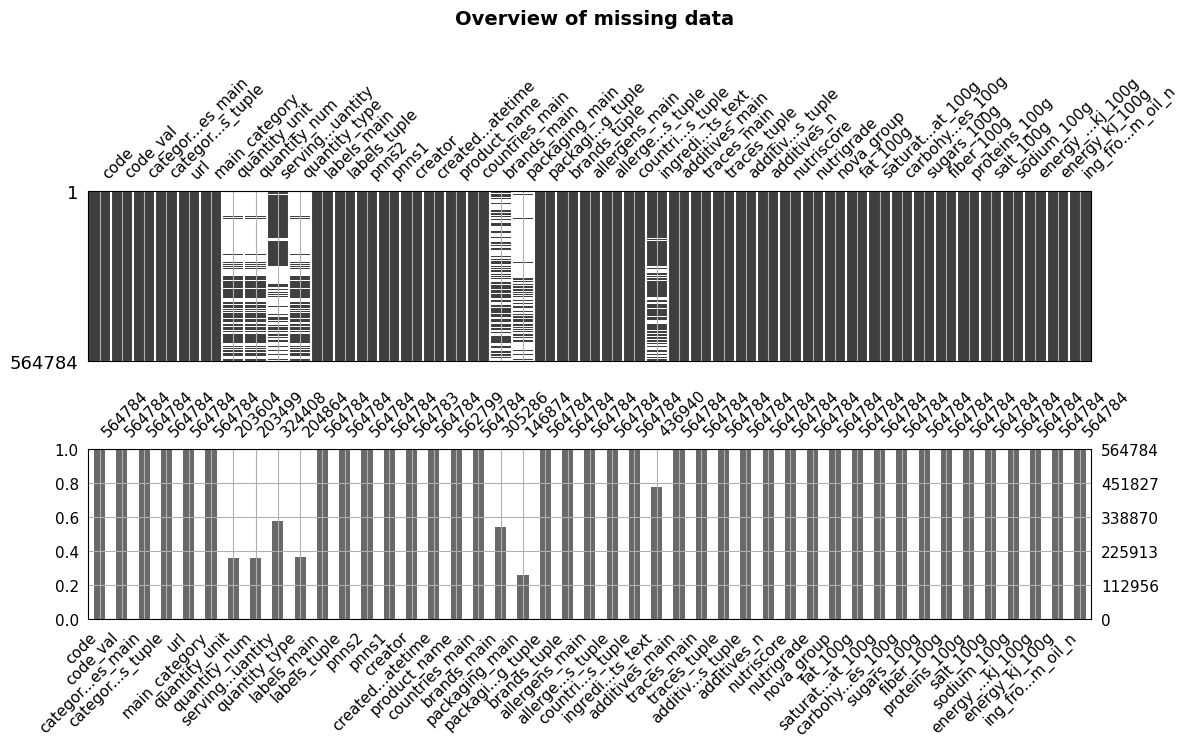

In [17]:
plot_export_missing(df, df.columns, 'A_0_missing_vals.png',
                    'Overview of missing data',
                     shorten_label=True)

In [0]:
# Splitting columns in categories

info_cols =  ['code','code_val','url','creator','created_datetime',
              'product_name', 'ingredients_text']
cols_1_Q = ['nutriscore','fat_100g','carbohydrates_100g','proteins_100g',
            'salt_100g','saturated_fat_100g', 'sugars_100g', 'sodium_100g',
            'energy_kj_100g','energy_from_fat_kj_100g']
cols_1_C = ['nutrigrade', 'countries_main', 'categories_main']
cols_1_C_ = ['countries_tuple', 'categories_tuple']

cols_2_Q = ['fiber_100g']
cols_2_C = ['nova_group', 'pnns1', 'pnns2', 'main_category']
cols_2_C_ = []

cols_3_Q = ['ing_from_palm_oil_n','additives_n']
cols_3_C = ['additives_main','labels_main','allergens_main', 'traces_main']
cols_3_C_ = ['additives_tuple','labels_tuple','allergens_tuple', 'traces_tuple']

cols_4_Q = ['quantity_num', 'serving_quantity']
cols_4_C = ['brands_main','packaging_main', 'quantity_type','quantity_unit']
cols_4_C_ = ['brands_tuple','packaging_tuple']

## 1 Univariate analysis

### 1.1 Quantitative data

#### Histograms

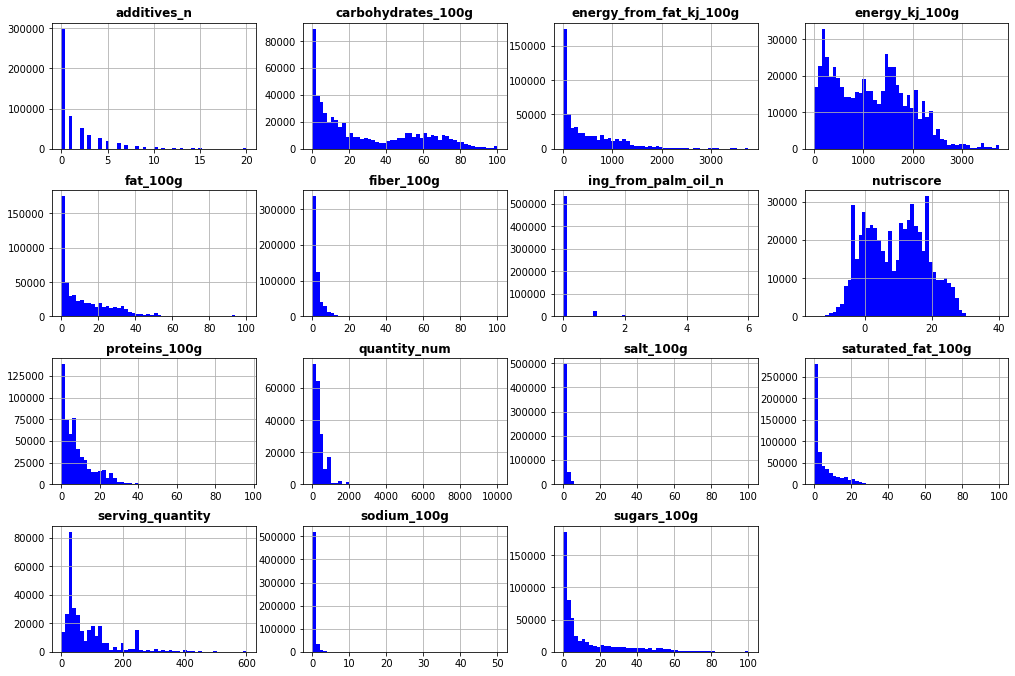

In [19]:
# Plotting histograms of the main quantitative continuous columns

quant_cols = cols_1_Q + cols_2_Q + cols_3_Q + cols_4_Q
# fig = plt.figure(figsize=(14,10))
fig = df[quant_cols].hist(figsize=(18,6), bins=50, color='b',
                        xlabelsize=10, ylabelsize=10);
[x.title.set_fontweight('bold') for x in fig.ravel()];
plt.tight_layout(w_pad=1, h_pad=-0.8)
plt.gcf().set_size_inches(14,10)
# plt.savefig(os.getcwd()+'/FIG/'+'A_1_1_histograms.png', dpi=400);
plt.show()

#### Normality test

Let's test normality of the distribution of our quantitative data

In [0]:
quant_cols = cols_1_Q + cols_2_Q + cols_3_Q + cols_4_Q

In [0]:
# Normality Tests

from scipy.stats import shapiro, normaltest, anderson

def normality_tests(data, print_opt=False):
    df_res = pd.DataFrame([])
    data_notna = data[data.notna()]
    # Shapiro-Wilk - D'Agostino's K^2
    for f_name, func in zip(['Shapiro-Wilk', "D'Agostino K^2"],[shapiro, normaltest]):
        stat, p = func(data_notna)
        df_res.loc[f_name,'stat'] = stat
        df_res.loc[f_name,'p_value'] = p
        if print_opt: print('---'+f_name) 
        if print_opt: print('stat=%.3f, p=%.3f' % (stat, p))
        df_res.loc[f_name,'res'] = [p > 0.05]
        if p > 0.05:
            if print_opt: print('Probably Gaussian')
        else:
            if print_opt: print('Probably not Gaussian')
    # Anderson-Darling
    result = anderson(data_notna)
    if print_opt: print('---'+'Anderson-Darling')
    df_res.loc['Anderson-Darling','stat'] = result.statistic
    if print_opt: print('stat=%.3f' % (result.statistic))
    res_and = [(int(result.significance_level[i]),result.statistic < res)\
                   for i,res in enumerate(result.critical_values)]
    df_res.loc['Anderson-Darling','res'] = str(res_and)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            if print_opt: print('Probably Gaussian at the %.1f%% level' % (sl))
        else:
            if print_opt: print('Probably not Gaussian at the %.1f%% level' % (sl))
    return df_res

In [0]:
# Plotting histograms and qqplots of the main quantitative continuous columns

def plot_hist_qqplot(data, name):
    fig, axs = plt.subplots(1,2)
    # histogram
    axs[0].hist(data, color='b', bins =25);
    # using statsmodels qqplot's module
    qqplot(data, line='r', ax=axs[1])
    plt.gcf().set_size_inches(10,2.5)
    fig.suptitle(name, fontweight='bold', size=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

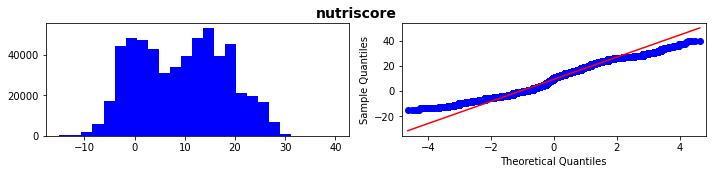

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.975774,0.0,False
D'Agostino K^2,105756.715018,0.0,False
Anderson-Darling,4985.438449,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


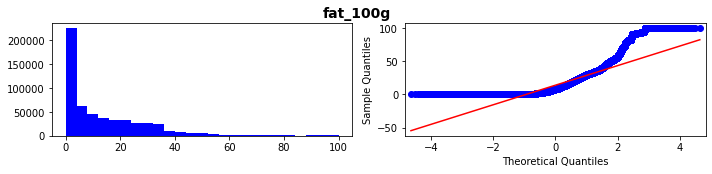

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.793234,0.0,False
D'Agostino K^2,215100.780694,0.0,False
Anderson-Darling,31143.227076,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


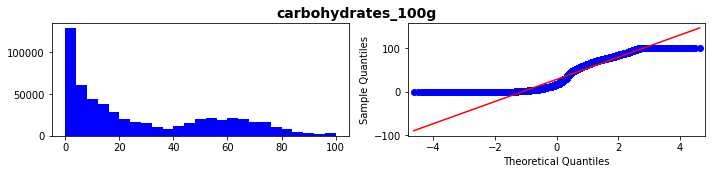

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.872956,0.0,False
D'Agostino K^2,114954.533896,0.0,False
Anderson-Darling,27125.357214,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


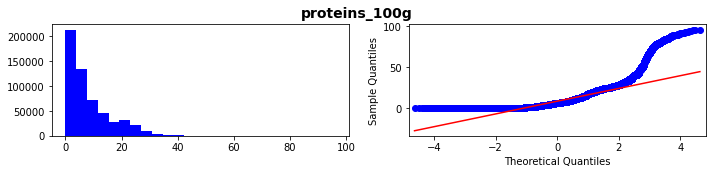

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.822850,0.0,False
D'Agostino K^2,257370.092724,0.0,False
Anderson-Darling,23865.042095,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


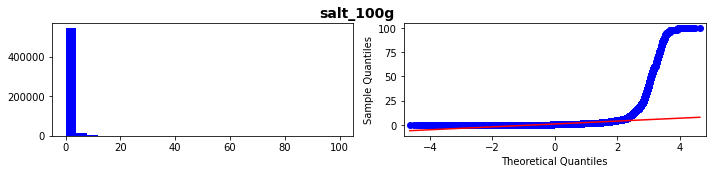

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,2.358339e-01,0.0,False
D'Agostino K^2,1.163732e+06,0.0,False
Anderson-Darling,1.020665e+05,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


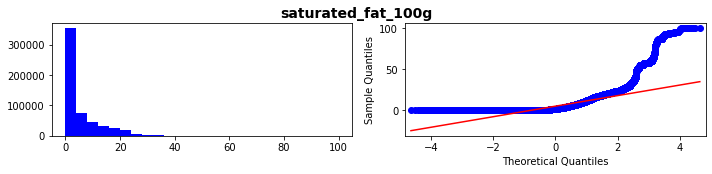

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.691135,0.0,False
D'Agostino K^2,383386.491258,0.0,False
Anderson-Darling,49028.989581,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


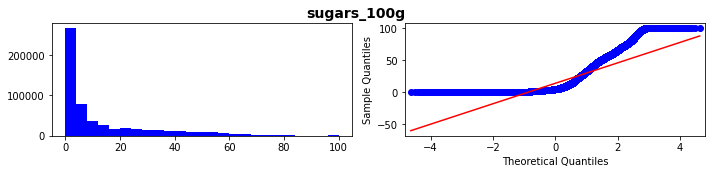

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.735106,0.0,False
D'Agostino K^2,185494.744297,0.0,False
Anderson-Darling,55662.921710,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


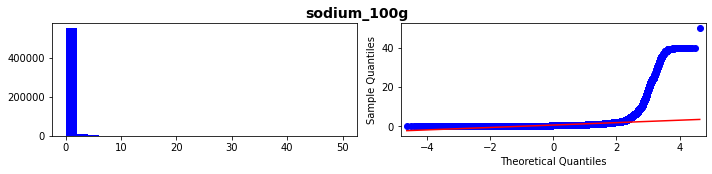

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,2.270256e-01,0.0,False
D'Agostino K^2,1.151601e+06,0.0,False
Anderson-Darling,1.056878e+05,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


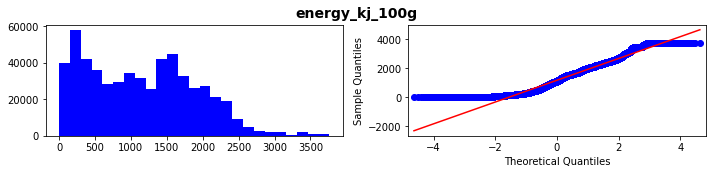

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.959560,0.0,False
D'Agostino K^2,24980.951729,0.0,False
Anderson-Darling,5846.849807,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


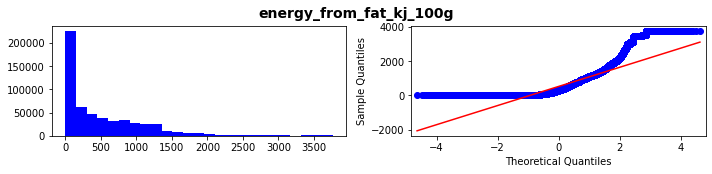

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.793234,0.0,False
D'Agostino K^2,215100.780023,0.0,False
Anderson-Darling,31143.227061,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


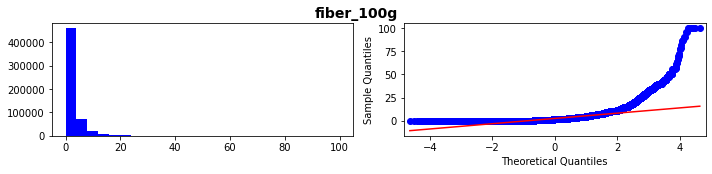

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.658721,0.0,False
D'Agostino K^2,522935.161931,0.0,False
Anderson-Darling,43316.600232,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


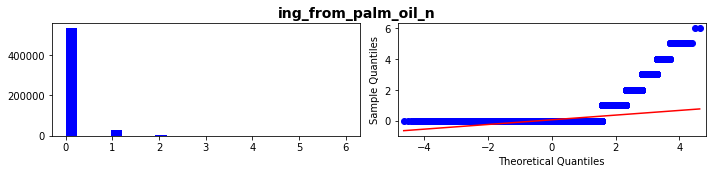

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.231062,0.0,False
D'Agostino K^2,613344.829829,0.0,False
Anderson-Darling,192518.390655,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


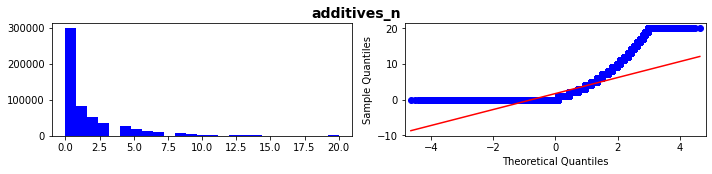

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.658729,0.0,False
D'Agostino K^2,303652.821321,0.0,False
Anderson-Darling,64866.418549,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


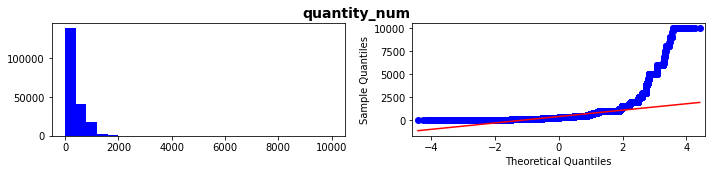

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.573635,0.0,False
D'Agostino K^2,256605.549439,0.0,False
Anderson-Darling,16525.353934,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


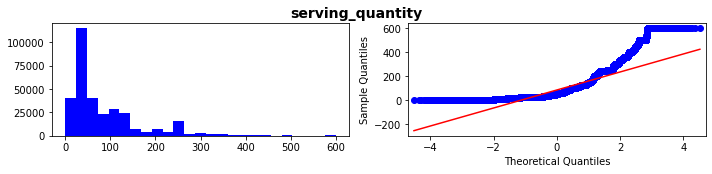

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.768308,0.0,False
D'Agostino K^2,140941.669275,0.0,False
Anderson-Darling,22957.259473,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


In [23]:
# Plotting QQplots and normality tests stats

for i, c in enumerate(quant_cols,1):
    if c in cols_4_Q:
        plot_hist_qqplot(df[c].dropna().values, c)
        display(normality_tests(df[c].dropna(), print_opt=False))
    else:
        plot_hist_qqplot(df[c].values, c)
        display(normality_tests(df[c], print_opt=False))
    # plt.savefig(os.getcwd()+'/FIG/'+'A_1_1_qqplots.png', dpi=400);
plt.show()

### 1.2 Qualitative data

In [0]:
qual_cols = cols_1_C + cols_2_C + cols_3_C + cols_4_C

#### Bar plots

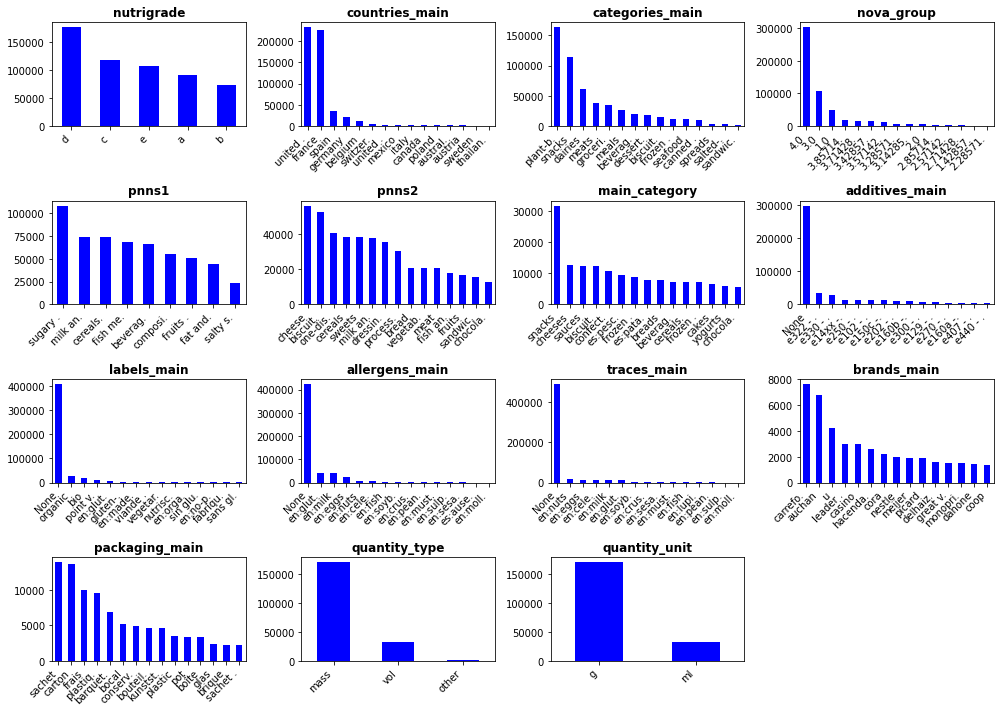

In [25]:
# Plotting bar plots of the main categorical columns

fig = plt.figure(figsize=(14,10))
for i, c in enumerate(qual_cols,1):
    ax = fig.add_subplot(4,4,i)
    ser = df[c].value_counts()
    if ser.shape[0]>15:
        ser[0:15].plot.bar(color='b',ax=ax)
    else:
        ser.plot.bar(color='b',ax=ax)
    ax.set_title(c, fontweight='bold')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [s[0:7]+'.' if len(s)>7 else s for s in labels]
    ax.axes.set_xticklabels(short_labels)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.savefig(os.getcwd()+'/FIG/'+'A_1_2_bar_plots.png', dpi=400);
plt.show()

#### Distribution depending on categorical data

In [0]:
boxplot_cols = quant_cols

for nutrigrades subsets

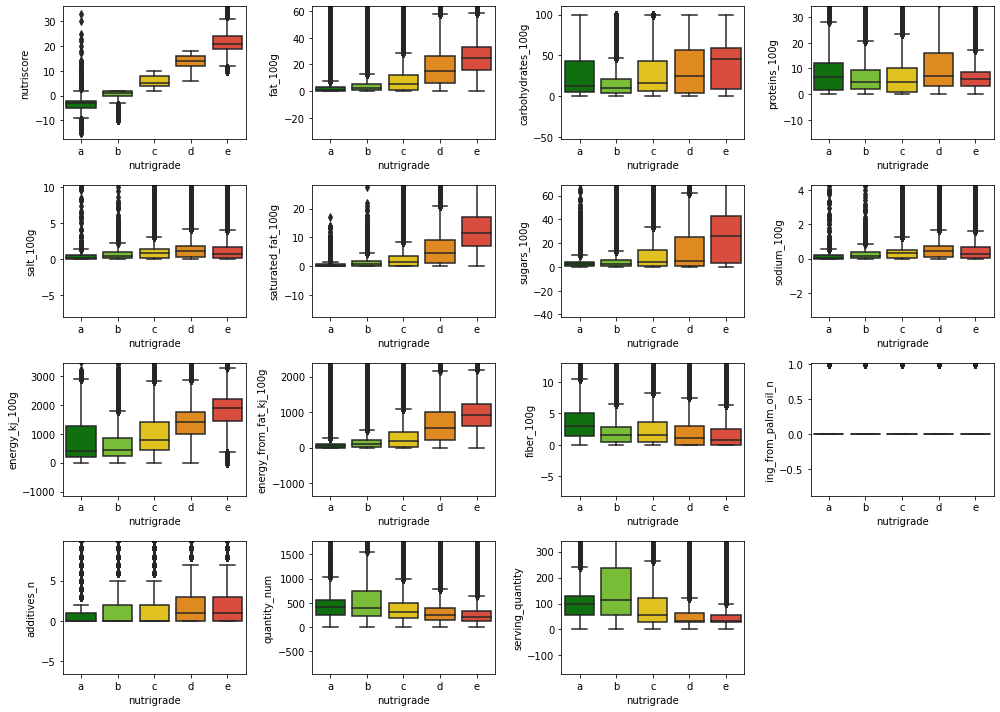

In [27]:
# nutriscore

nutri_pal = ['#008000', '#78D222', '#FFD700', '#FF8D00' , '#F23824']

fig = plt.figure(figsize=(14,10))
with sns.color_palette(nutri_pal):
    for i, c in enumerate(boxplot_cols,1):
        ax = fig.add_subplot(4,4,i)
        sns.boxplot(data=df, x='nutrigrade', y=c, order=list('abcde'), ax=ax)
        min = df[c].mean()-3*df[c].std()
        max = df[c].mean()+3*df[c].std()
        plt.ylim(min,max)
plt.tight_layout()
# plt.savefig(os.getcwd()+'/FIG/'+'A_1_2_nutrigrade_boxplots.png', dpi=400);
plt.show()

for categories subsets

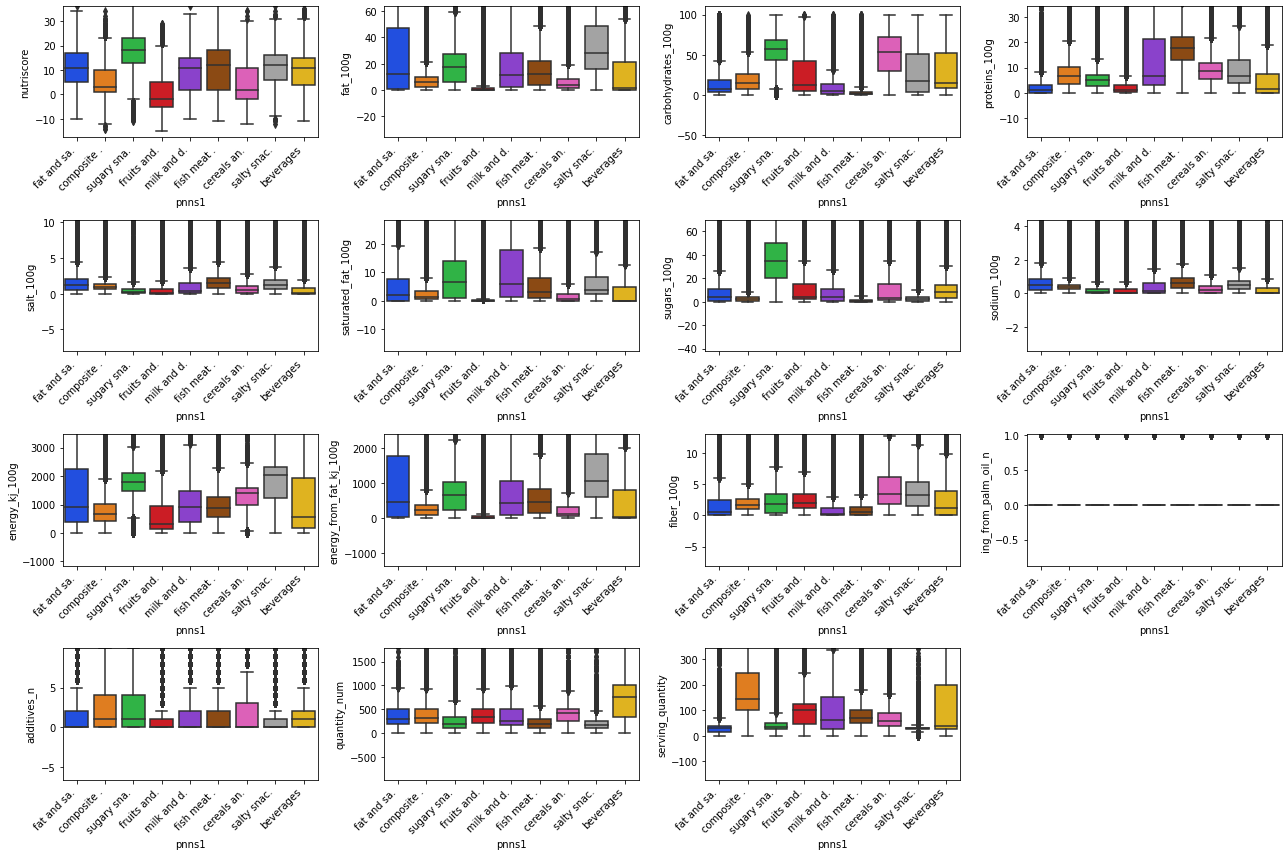

In [28]:
# pnns1

pnns1_pal = sns.color_palette(palette='bright')

fig = plt.figure(figsize=(18,12))
with sns.color_palette(pnns1_pal):
    for i, c in enumerate(boxplot_cols,1):
        ax = fig.add_subplot(4,4,i)
        sns.boxplot(data=df, x='pnns1', y=c, ax=ax)# order=list('abcde')
        min = df[c].mean()-3*df[c].std()
        max = df[c].mean()+3*df[c].std()
        plt.ylim(min,max)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[0:10]+'.' if len(s)>10 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.savefig(os.getcwd()+'/FIG/'+'A_1_2_pnns1_boxplots.png', dpi=400);
plt.show()

In [29]:
df['pnns1'].unique()

array(['fat and sauces', 'composite foods', 'sugary snacks',
       'fruits and vegetables', 'milk and dairy products',
       'fish meat eggs', 'cereals and potatoes', 'salty snacks',
       'beverages'], dtype=object)

It looks like some pnns1 categories have a better mean nutriscore as others.

Let's calculate the means and determine if this is statistically significant.

In [30]:
# df[df['pnns1']=='fruits and vegetables']
with pd.option_context("display.float_format", '{:,.2f}'.format):
    display(df.groupby(['pnns1'])['nutriscore'].agg([np.median, np.mean, np.std]))

,median,mean,std
pnns1,,,
beverages,11.00,10.23,7.22
cereals and potatoes,2.00,4.05,7.62
composite foods,3.00,4.93,6.26
fat and sauces,11.00,11.19,7.44
fish meat eggs,12.00,10.37,8.84
fruits and vegetables,-2.00,0.31,6.81
milk and dairy products,11.00,8.79,7.20
salty snacks,12.00,10.99,7.21
sugary snacks,18.00,16.86,7.54


## 2 Bivariate analysis

### 2.0 Time analysis

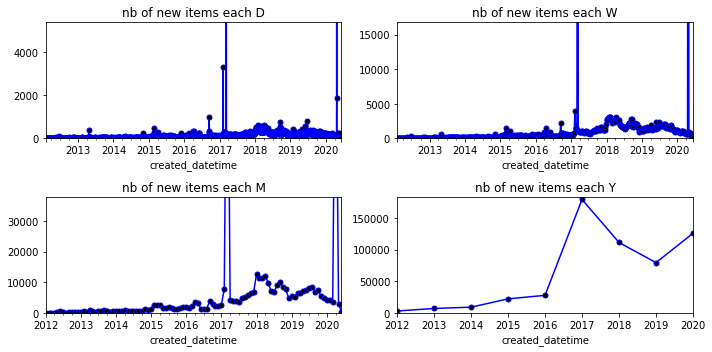

In [31]:
# Plotting number of new items through time
fig = plt.figure(figsize=(10,5))
for i,per in enumerate(['D', 'W', 'M', 'Y'],1):
    ax = fig.add_subplot(2,2,i)
    t_ser = df.groupby(pd.Grouper(key='created_datetime', freq=per)).size()
    t_ser.plot(ax=ax, ms=5, marker='o', mfc='k', color='b', ls='-')
    ax.set(ylim=(0,np.mean(t_ser)+2*np.std(t_ser)))
    ax.set_title("nb of new items each "+per)
fig.tight_layout()
# plt.savefig(os.getcwd()+'/FIG/'+'A_2_0_new_items_thr_time.png', dpi=400);
plt.show()

### 2.1 Linear correlation

In [0]:
def plot_heatmap(corr, title, figsize=(8,4), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20), rect=False,
                 fmt='.2f'):
    fig, ax = plt.subplots(figsize=figsize)
    if rect==True:
        mask=None
    else:
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    palette = palette
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=True, annot_kws={"size": 10},fmt=fmt,
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None},
                     xticklabels= corr.columns, yticklabels = corr.index)
    ax.tick_params(labelsize=10,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)
    plt.show()

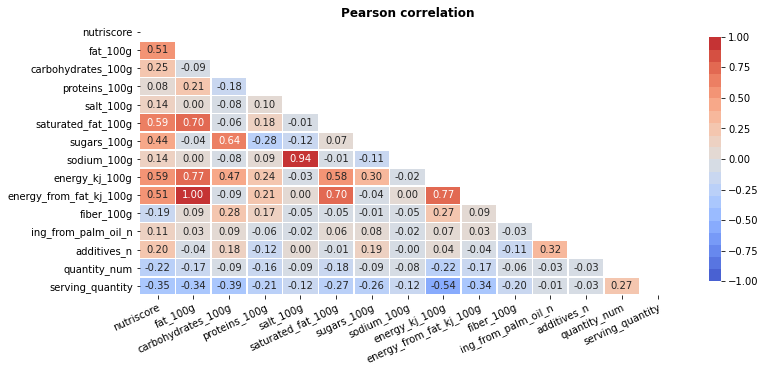

In [33]:
# Linear correlation (Pearson)

cols = quant_cols
pears_corr = df[cols].corr()
plot_heatmap(pears_corr, rect=False, title="Pearson correlation", figsize=(12,5))
# plt.savefig(os.getcwd()+'/FIG/'+'A_2_1_pearson_corr.png', dpi=400);
plt.show()

Some of the correlations are quite obvious, as for example:
- fat -> energy
- sugars -> carbohydrates
- fat, saturated, fat, sugars, energy -> nutriscore
- nutriscore -> nutrigrade
More suprisingly :
- more fibers can be found in high energy products

As we know from its formula, nutriscore:
- increases with energy, saturated fat, sugar and salt
- decreases with fibers, proteins and fruits and vegetable content

However, which is more interesting is that the value of correlation coefficient indicates that in the case of most of the actual products, the main factors that are correlated with nutriscore are (decreasing order):
- fat, energy, saturated fat, carbohydrates, sugar
- whereas sodium is very weakly correlated to a high nutriscore.

__=> Food industry should focus primarily on decreasing fat to lower the nutriscore of their products__.


### 2.2 Correlation tests

In [0]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def correlation_tests(data1, data2, print_opt=False):
    df_res = pd.DataFrame([])
    # data1_notna = data1[data1.notna()]
    # Pearson, Spearman, Kendall
    for f_name, func in zip(['Pearson', 'Spearman', 'Kendall'],[pearsonr, spearmanr, kendalltau]):
        stat, p = func(data1, data2)
        df_res.loc[f_name,'stat'] = stat
        df_res.loc[f_name,'p_value'] = p
        if print_opt: print('---'+f_name)
        if print_opt: print('stat=%.3f, p=%.3f' % (stat, p))
        if print_opt:print('Probably independent') if p > 0.05 else print('Probably dependent')
    return df_res

In [35]:
# Correlation test

test_couples = [('fat_100g','nutriscore'), ('carbohydrates_100g','nutriscore'),
                ('fat_100g','nutriscore'), ('energy_kj_100g','nutriscore'),
                ('fiber_100g','nutriscore'), ('energy_kj_100g','fiber_100g'),
                ('fat_100g','fiber_100g'), ('fat_100g','fiber_100g')]

for tup in test_couples:
    print('------'+str(tup).upper()+'-----')
    c1, c2 = tup
    display(correlation_tests(df[c1], df[c2], print_opt=False))

------('FAT_100G', 'NUTRISCORE')-----


,stat,p_value
Pearson,0.505738,0.0
Spearman,0.592827,0.0
Kendall,0.427212,0.0


------('CARBOHYDRATES_100G', 'NUTRISCORE')-----


,stat,p_value
Pearson,0.245655,0.0
Spearman,0.193945,0.0
Kendall,0.136297,0.0


------('FAT_100G', 'NUTRISCORE')-----


,stat,p_value
Pearson,0.505738,0.0
Spearman,0.592827,0.0
Kendall,0.427212,0.0


------('ENERGY_KJ_100G', 'NUTRISCORE')-----


,stat,p_value
Pearson,0.592811,0.0
Spearman,0.611551,0.0
Kendall,0.445258,0.0


------('FIBER_100G', 'NUTRISCORE')-----


,stat,p_value
Pearson,-0.191755,0.0
Spearman,-0.222169,0.0
Kendall,-0.156633,0.0


------('ENERGY_KJ_100G', 'FIBER_100G')-----


,stat,p_value
Pearson,0.268367,0.0
Spearman,0.279048,0.0
Kendall,0.191224,0.0


------('FAT_100G', 'FIBER_100G')-----


,stat,p_value
Pearson,0.086857,0.0
Spearman,0.116408,0.0
Kendall,0.083362,0.0


------('FAT_100G', 'FIBER_100G')-----


,stat,p_value
Pearson,0.086857,0.0
Spearman,0.116408,0.0
Kendall,0.083362,0.0


### 2.3 Correlation with Predictive Power Score (decision tree based)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

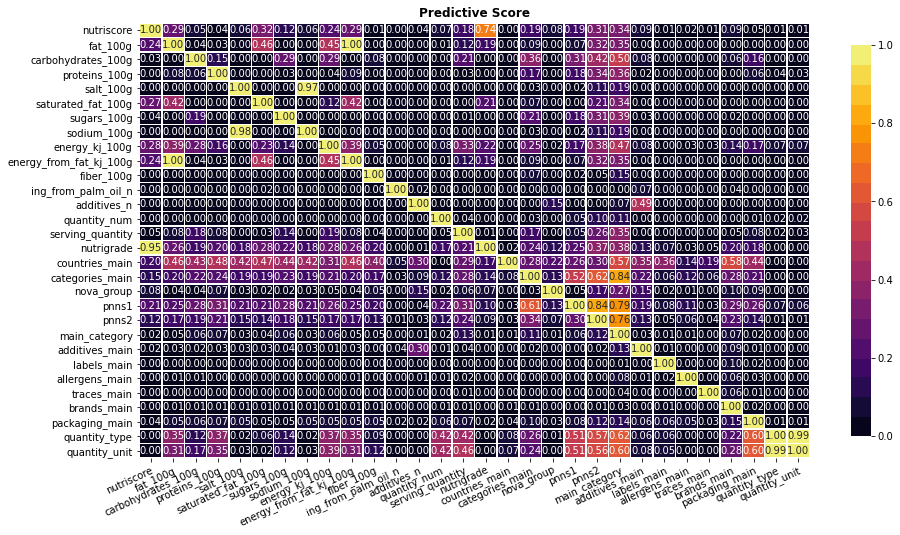

In [37]:
# Predictive Power Score (ppscore)

cols = quant_cols + qual_cols

pps_corr = pps.matrix(df[cols])
plot_heatmap(pps_corr, title="Predictive Score", 
             vmin=0, center=0.5, figsize=(15,8), rect=True,
             palette=sns.color_palette("inferno", 20))
# plt.savefig(os.getcwd()+'/FIG/'+'A_2_3_ppscore_corr.png', dpi=400);
plt.show()

It seems that categories have a strong relation to most of the nutritional values.

countries as well seem to have a strong relationship to nutritional values. 

### 2.4 Contingency table and Chi-squared

In [40]:
## Creating table of contingency

data_crosstab = pd.crosstab(df['pnns1'], 
                            df['nutrigrade'],  
                               margins = True)
display(data_crosstab)

nutrigrade,a,b,c,d,e,All
pnns1,,,,,,
beverages,2977,8058,14576,20860,20318,66789
cereals and potatoes,26427,12602,15602,16165,2814,73610
composite foods,8655,15597,18157,11175,1711,55295
fat and sauces,2203,3881,13678,15865,8438,44065
fish meat eggs,8487,8566,12640,23159,15233,68085
fruits and vegetables,28690,5541,11945,4777,430,51383
milk and dairy products,7931,13588,15129,32855,4349,73852
salty snacks,1458,1891,6889,9057,3899,23194
sugary snacks,4032,3337,9099,41979,50064,108511


In [41]:
# Chi-Squared Test
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data_crosstab)
print('---'+"Chi-squared")
print('stat=%.3f, p=%.8f' % (stat, p))
print('Probably independent') if p > 0.05 else print('Probably dependent')

---Chi-squared
stat=226571.453, p=0.00000000
Probably dependent


### 2.5 ANOVA

In [0]:
## Test de normalité à faire dans les sous-groupes

In [44]:
# Analysis of Variance Test (ANOVA)

from scipy.stats import f_oneway

# gb = df.groupby('nutrigrade')
# data1 = df.loc[gb.groups['a'], 'fat_100g']
# data2 = df.loc[gb.groups['b'], 'fat_100g']

gb = df.groupby('pnns2')
data1 = df.loc[gb.groups['meat'], 'nutriscore']
data2 = df.loc[gb.groups['fish and seafood'], 'nutriscore']

stat, p = f_oneway(data1, data2)
print('---'+" ANOVA")
print('stat=%.3f, p=%3.8f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

--- ANOVA
stat=0.118, p=0.73143310
Probably same distribution



In [45]:
import scipy.stats as st
t, p = st.ttest_ind(data1, data2, equal_var=True)
print('\nt-test: p-value = ',p)


t-test: p-value =  0.7314330992828997


### 2.6 Non-parametric statistical hypothesis tests

In [46]:
# Example of the Mann-Whitney U Test
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(data1, data2)
print('---'+" U-test (Mann-Whitney)")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

# Example of the Wilcoxon Signed-Rank Test
from scipy.stats import wilcoxon
stat, p = wilcoxon(data1, data2)
print('---'+" Signed-rank (Wilcoxon)")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

# Example of the Kruskal-Wallis H Test
from scipy.stats import kruskal
stat, p = kruskal(data1, data2)
print('---'+" H-test (Kruskal-Wallis)")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')
    
# Example of the Friedman Test
from scipy.stats import friedmanchisquare
stat, p = friedmanchisquare(data1, data2, data3)
print('---'+" ANOVA")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

--- U-test (Mann-Whitney)
stat=179722413.500, p=0.018
Probably not the same distribution



ValueError: ignored

### 2.7 Pair plots

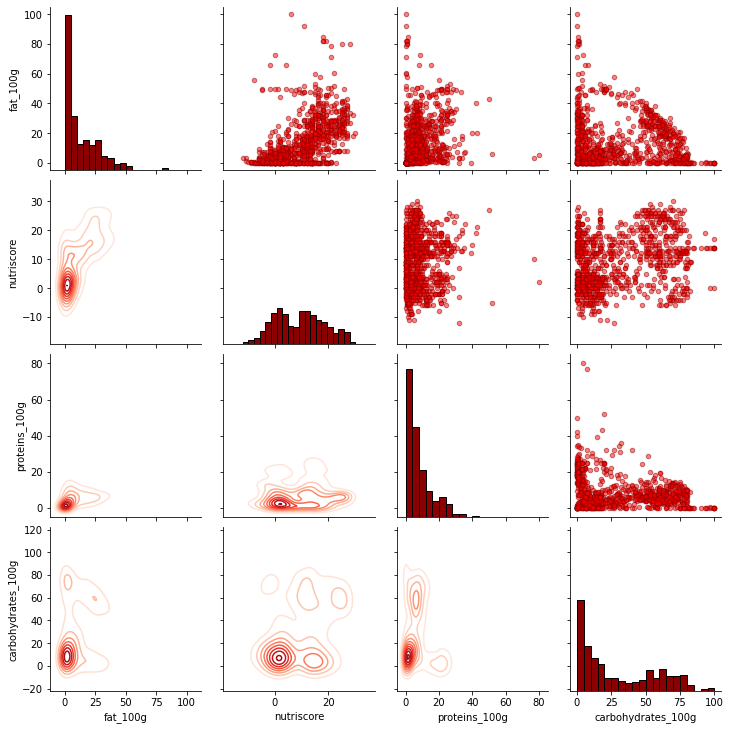

In [47]:
# Scatterplot matrix (too much data -> on a sample)
cols = ['fat_100g', 'nutriscore','proteins_100g','carbohydrates_100g']
df_sample = df.sample(1000)

grid = sns.PairGrid(data=df_sample,
                    vars=cols, height=2.5)
grid = grid.map_upper(plt.scatter, marker='o', edgecolors='darkred',
                      alpha=0.5, color='red', s=20)
# grid = grid.map_upper(testcorr)
grid = grid.map_diag(plt.hist, bins = 20, color = 'darkred', edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')

# plt.savefig(os.getcwd()+'/FIG/'+'A_2_7_pairplot_grid.png', dpi=400);
plt.show()

## 3 Multivariable analysis

### 3.1 PCA (Principal Component Analysis)

In [0]:
from P3_Analysis_functions import *

In [16]:
##### Principal Component Analysis #####

np.set_printoptions(formatter={'float': '{: 6.2f}'.format})

## --Feature and index (dropna) selection for PCA
pca_cols = cols_1_Q + cols_2_Q + cols_3_Q
pca_cols = [c for c in pca_cols if c!='nutriscore']
id_code = df[pca_cols].dropna(how='any').index
X = df.loc[id_code, pca_cols].values

## --Data standardisation
print('-----standardisation-----')
X_sc = StandardScaler().fit_transform(X)
print(X_sc)

-----standardisation-----
[[ -0.34   0.02  -0.37 ...  -0.71  -0.22  -0.60]
 [ -0.81  -0.86  -0.86 ...  -0.04  -0.22  -0.60]
 [  0.50  -0.05  -0.43 ...   0.55  -0.22  -0.60]
 ...
 [  0.39   0.09  -0.11 ...  -0.46  -0.22  -0.60]
 [ -0.37   0.24  -0.66 ...  -0.04  -0.22   0.49]
 [ -0.53  -1.05   1.53 ...   0.50  -0.22  -0.60]]


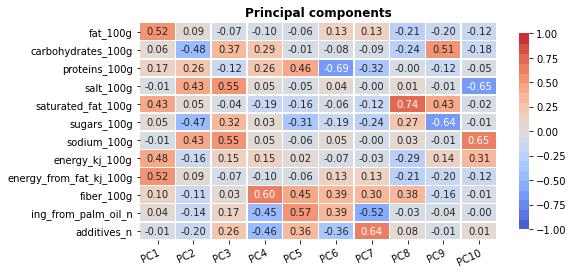

In [19]:
## Principal components calculation

n_comp = 10
pca = PCA(n_components=n_comp).fit(X_sc)

# coefficients of principal components (original features)
pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T
plot_heatmap(pca_df,'Principal components', vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),figsize=(8,4),rect=True)
# plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_principal_components.png', dpi=400);
plt.show()

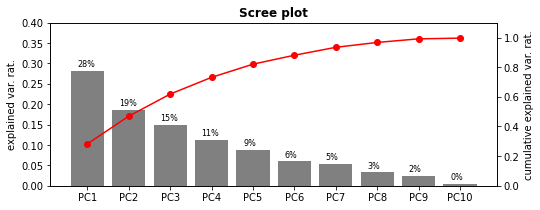

In [52]:
# Explained variance ratio

exp_var_rat = pca.explained_variance_ratio_
plt.bar(x=pca_df.columns,height=exp_var_rat, color='grey')
ax1 = plt.gca()
ax1.set(ylim=(0,0.4))
ax2 = ax1.twinx()
ax2.plot(exp_var_rat.cumsum(), 'ro-')
ax2.set(ylim=(0,1.1))
ax1.set_ylabel('explained var. rat.')
ax2.set_ylabel('cumulative explained var. rat.')
for i, p in enumerate(ax1.patches):
    ax1.text( p.get_width()/5 + p.get_x(), p.get_height()+ p.get_y()+0.01,
             '{:.0f}%'.format(exp_var_rat[i]*100),
                fontsize=8, color='k')
plt.gcf().set_size_inches(8,3)
plt.title('Scree plot', fontweight='bold')
# plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_scree_plot.png', dpi=400);
plt.show()

In [0]:
## KMeans Clustering

n_clust = 9
km = KMeans(n_clusters=n_clust).fit(X_sc)
clustK = km.labels_
df.loc[id_code, 'cluster_Kmeans'] = clustK

In [0]:
# Hierarchical Clustering

# Z = linkage(X_sc, 'ward')
# print(Z[0:15])
# plt.figure(figsize=(16,10))
# dendrogram(Z, labels = df.index, orientation = "right", count_sort='descending')
# plt.show()

# n_clust = 6
# clustH = fcluster(Z, n_clust, criterion='maxclust')
# df['cluster_HierClust'] = clustH
# clustH

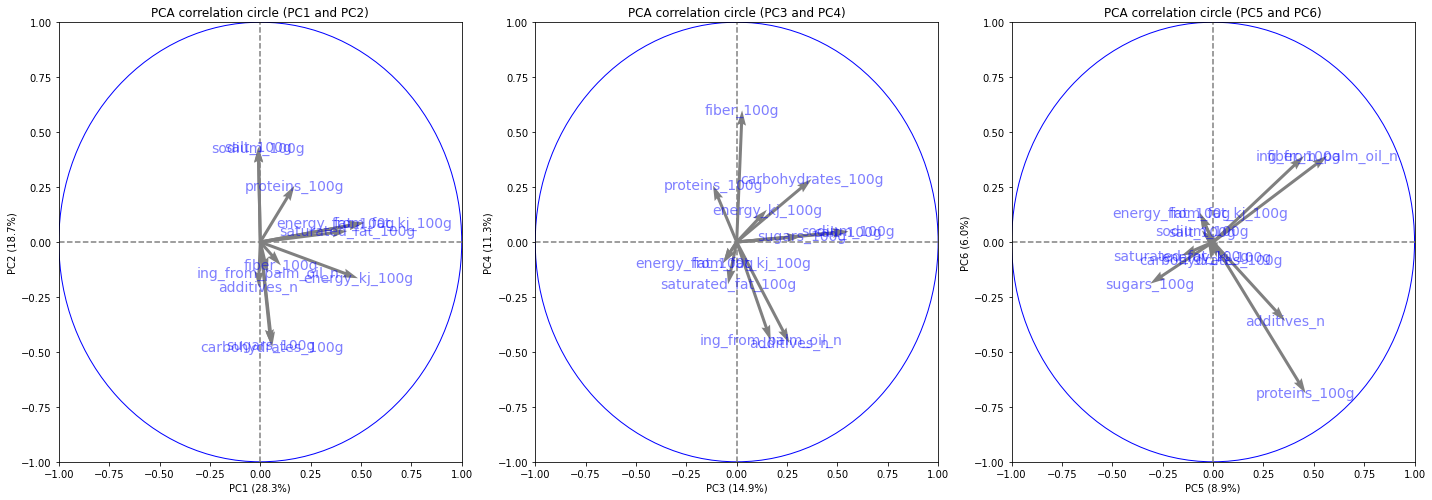

In [22]:
# Correlation circle

display_circles(pca.components_, n_comp, pca, [(0,1),(2,3),(4,5)],
                labels = np.array(pca_cols), width=20,  n_cols=3)
# plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_correlation_circle.png', dpi=400);
plt.show()

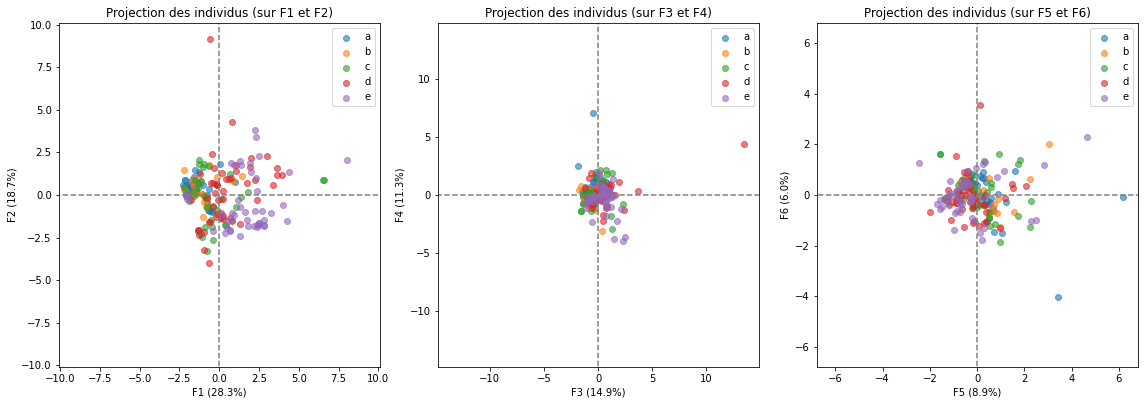

In [24]:
# Plotting a sample of values projected on first factorial planes

id_code_samp = pd.Series(id_code).sample(200)
X_samp = df.loc[id_code_samp, pca_cols].values
X_sc_samp = StandardScaler().fit_transform(X_samp)

display_factorial_planes(pca.transform(X_sc_samp), n_comp, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code_samp),
                         illus_var= df.loc[id_code_samp, 'nutrigrade'],
                         lab_on=False, alpha=0.6)

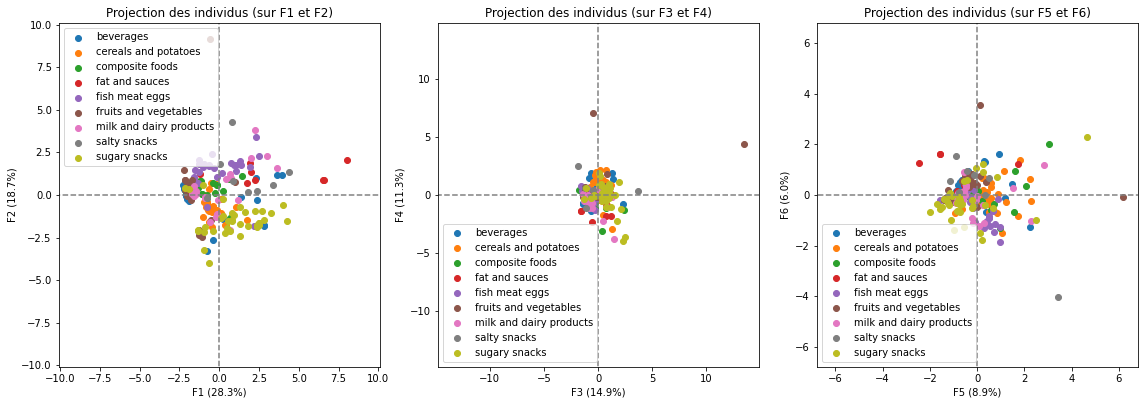

In [25]:
display_factorial_planes(pca.transform(X_sc_samp), n_comp, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code_samp),
                         illus_var= df.loc[id_code_samp, 'pnns1'],
                         lab_on=False)

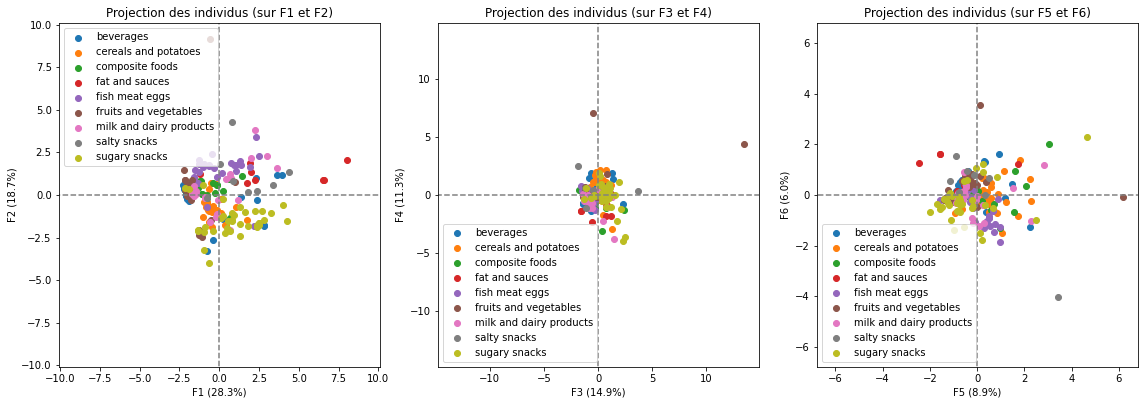

In [26]:
display_factorial_planes(pca.transform(X_sc_samp), n_comp, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code_samp),
                         illus_var= df.loc[id_code_samp, 'pnns1'],
                         lab_on=False)

---Chi-squared
stat=574234.197, p=0.000
Probably dependent


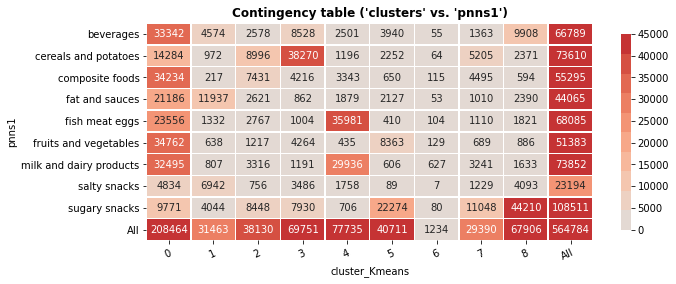

In [34]:
# Contingency table showing cluster vs. pnns1 categories

data_crosstab = pd.crosstab(df['pnns1'], 
                            df['cluster_Kmeans'],  
                               margins = True)
# display(data_crosstab)
# Chi-Squared Test
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data_crosstab)
print('---'+"Chi-squared")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably independent') if p > 0.05 else print('Probably dependent')

pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T
plot_heatmap(data_crosstab,"Contingency table ('clusters' vs. 'pnns1')",
             vmin=0, vmax=45000,figsize=(10,4),rect=True, fmt='.0f',
             palette=sns.color_palette("coolwarm", 20))
# plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_cont_tabl_clust_pnns1.png', dpi=400);
plt.show()